In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from analyse_fit_files.parse_fit_file import get_fit_file_data

/var/folders/jl/rprd_0wd5q3cqhg9wlpx09_00000gn/T/ipykernel_44299/1600060235.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def decimal_time2clock_time(decimaltime):
    minutes = int(decimaltime)
    seconds = (decimaltime*60) % 60
    return "%2d:%02d"%(minutes, seconds)

In [3]:
def mins_per_mile_or_km(meters_per_second, unit):
    meters_per_min = meters_per_second * 60
    meters_per_mile = 1609.34
    meters_per_kilometer = 1000
    try:
        if unit == "mile":
            mins_per_mile = meters_per_mile / meters_per_min
        if unit == "km":
            mins_per_kilometer = meters_per_kilometer / meters_per_min
    except ZeroDivisionError:
        return meters_per_second
    except TypeError:
        return meters_per_second
    if unit == "mile":
        return mins_per_mile
    if unit == "km":
        return mins_per_kilometer

In [43]:
def run_pace_curve(fit_file_dataframe):
    """
    this function will find the top average for the signal
    over the time in seconds for the duration of the fit file
    options:
        fit_file_dataframe: dataframe
            dataframe to find top average over time
    returns:
        run_pace_curve: dataframe
            top average over time dataframe
    """
    duration_in_seconds = int(fit_file_dataframe.index.max())
    top_average = []
    for second in tqdm(range(1, duration_in_seconds + 1)):
        temp = fit_file_dataframe.rolling(window=second)[
            [
                "position_lat_semicircles",
                "position_long_semicircles",
                "enhanced_altitude_m",
                "altitude_m",
                "distance_m",
                "enhanced_speed_m/s",
                "speed_m/s",
                "heart_rate_bpm",
                "cadence_rpm",
            ]
        ].mean()
        top_speed = mins_per_mile_or_km(temp["speed_m/s"].max(), "km")
        top_bpm = temp["heart_rate_bpm"].max()
        top_average.append(
            {
                "timestamp_None": second,
                "speed_pace": top_speed,
                "heart_rate": top_bpm,
            }
        )

    run_pace_curve = pd.DataFrame(top_average)
    return run_pace_curve

In [44]:
def ride_power_curve(fit_file_dataframe):
    """
    this function will find the top average for the signal
    over the time in seconds for the duration of the fit file
    options:
        fit_file_dataframe: dataframe
            dataframe to find top average over time
    returns:
        ride_power_curve: dataframe
            top average over time dataframe
    """
    duration_in_seconds = int(fit_file_dataframe.index.max())
    top_average = []
    for second in tqdm(range(1, duration_in_seconds + 1)):
        temp = fit_file_dataframe.rolling(window=second)[
            [
                "position_lat_semicircles",
                "position_long_semicircles",
                "enhanced_altitude_m",
                "altitude_m",
                "distance_m",
                "enhanced_speed_m/s",
                "speed_m/s",
                "heart_rate_bpm",
                "cadence_rpm",
                "power_watts",
            ]
        ].mean()
        top_power = temp["power_watts"].max()
        top_bpm = temp["heart_rate_bpm"].max()
        top_average.append(
            {
                "timestamp_None": second,
                "speed_pace": top_power,
                "heart_rate": top_bpm,
            }
        )

    ride_power_curve = pd.DataFrame(top_average)
    return ride_power_curve

In [ ]:
ride = get_fit_file_data(
    "/Users/kevin/repos/analyse-fit-files/data/Zwift_-_Going_Coastal_in_Watopia.fit"
)
power = ride_power_curve(ride)

In [74]:
pace = get_fit_file_data(
    "/Users/kevin/repos/analyse-fit-files/data/Morning_Run_2024_02_04.fit"
)
speed = run_pace_curve(pace)

secondary = False
if secondary:
    pace1 = get_fit_file_data(
        "/Users/kevin/repos/analyse-fit-files/data/Morning_Run_2024_01_18.fit"
    )
    speed1 = run_pace_curve(pace1)

9172it [00:07, 1155.63it/s]
100%|██████████| 9171/9171 [00:31<00:00, 294.38it/s]


[datetime.date(2024, 2, 4)]


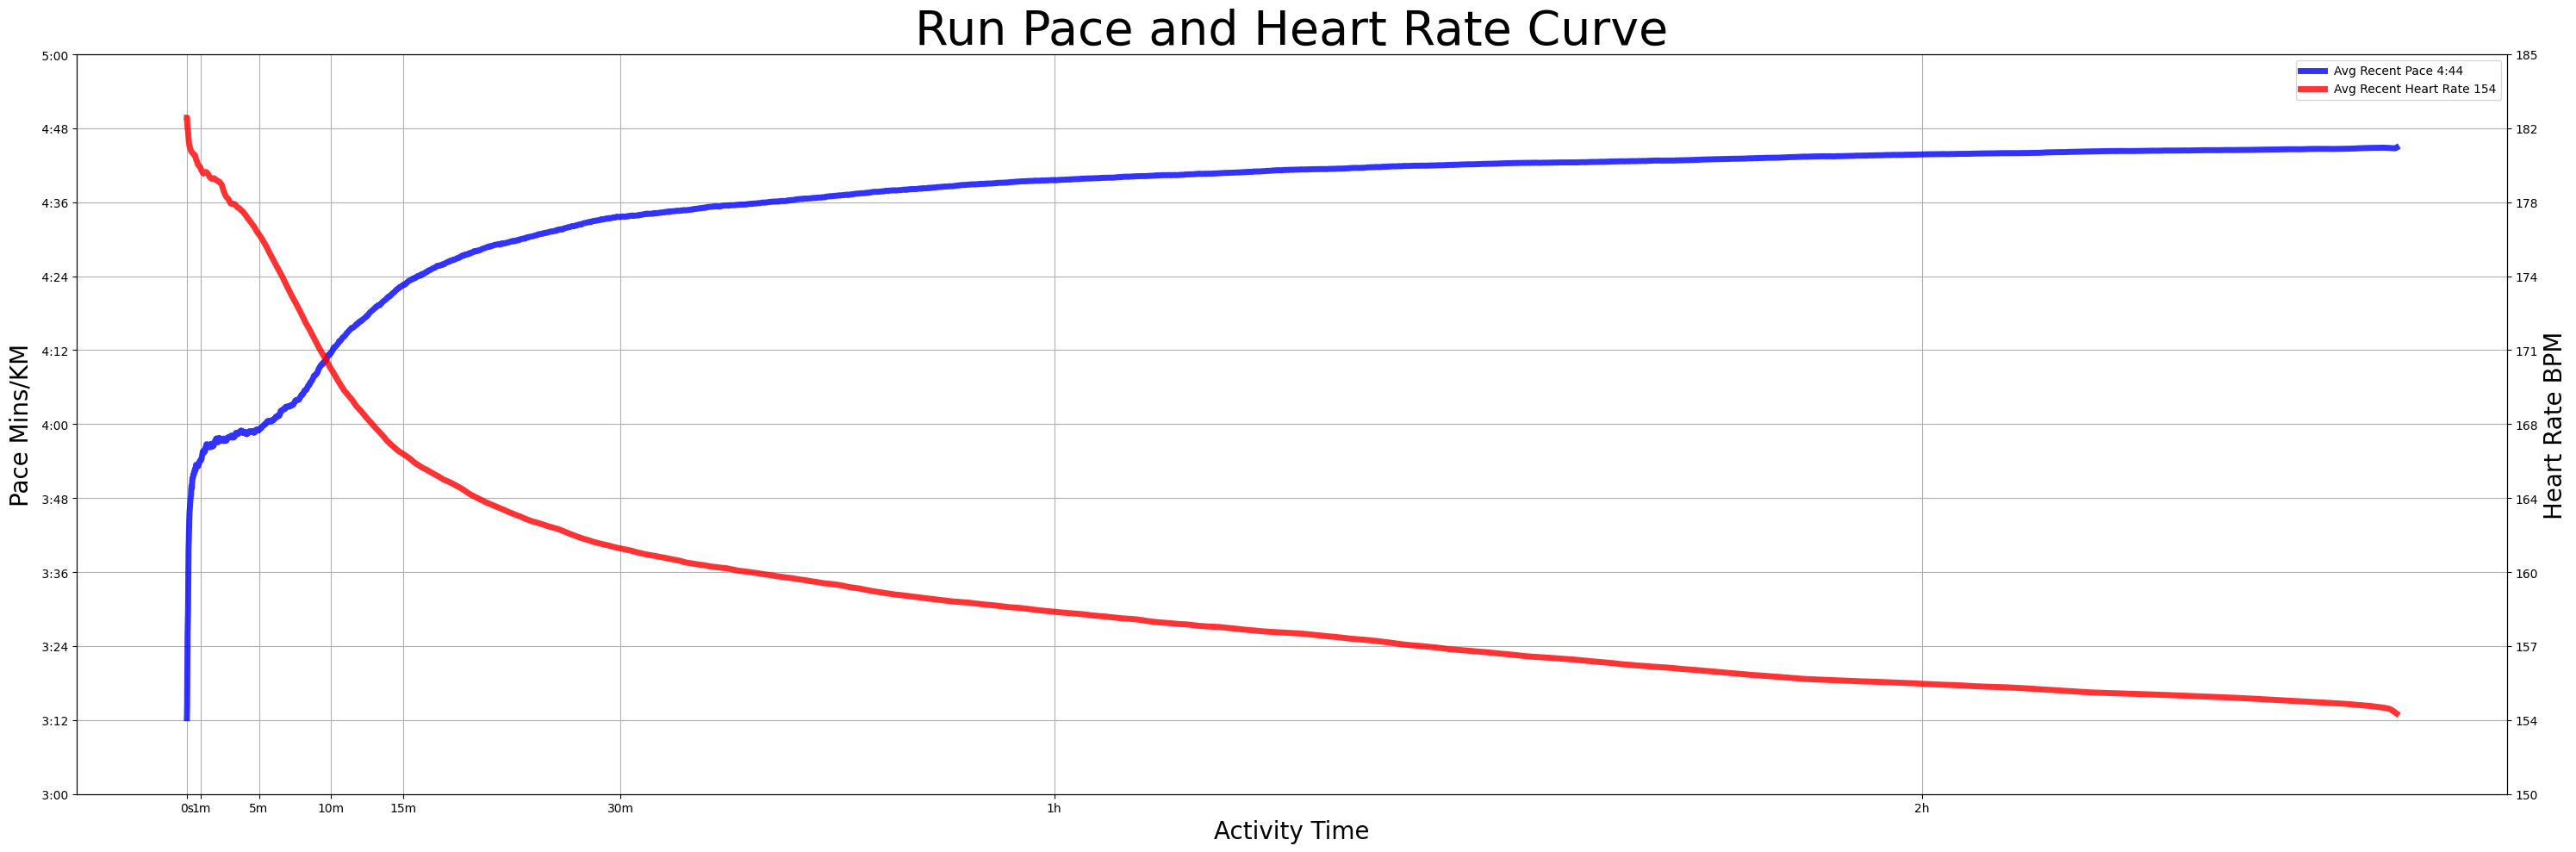

In [75]:
# data info
print(pace["timestamp_None"].dt.date.unique())  # primary plot date
if secondary:
    print(pace1["timestamp_None"].dt.date.unique())  # secondary plot date

# plot properties
fig, ax1 = plt.subplots(figsize=(30, 10))  # make the plot
plt.title(
    "Run Pace and Heart Rate Curve",
    fontsize=40,
)  # title the plot

# primary plot
sp = ax1.plot(
    speed["timestamp_None"],
    speed["speed_pace"],
    color="blue",
    alpha=0.8,
    linewidth=5,
    label=f'Avg Recent Pace{decimal_time2clock_time(mins_per_mile_or_km(pace["speed_m/s"].mean(), "km"))}',
)  # primary plot speed pace curve over activity time
if secondary:
    sp1 = ax1.plot(
        speed1["timestamp_None"],
        speed1["speed_pace"],
        color="blue",
        alpha=0.5,
        linewidth=5,
        label=f'Avg Past Pace{decimal_time2clock_time(mins_per_mile_or_km(pace1["speed_m/s"].mean(), "km"))}',
    )  # secondary plot speed pace curve over activity time
ax1.set_ylabel("Pace Mins/KM", fontsize=20)  # set the y label for pace
# x ticks
x_max_t = np.max(speed.index.max())  # total seconds in the data
x_max_t = x_max_t / 3600  # get the hours
x_max_t = np.floor(x_max_t)  # round downwards
x_max_t = int(x_max_t * 3600)  # maximum amount of seconds in the data
xlabticks = {
    "0s": 0,
    "1m": 60,
    "5m": 300,
    "10m": 600,
    "15m": 900,
    "30m": 1800,
    "1h": 3600,
    "2h": 7200,
    "3h": 10800,
    "4h": 14400,
    "5h": 18000,
    "6h": 21600,
    "7h": 25200,
    "8h": 28800,
    "9h": 32400,
    "10h": 36000,
    "11h": 39600,
    "12h": 43200,
    "13h": 46800,
    "14h": 50400,
    "15h": 54000,
    "16h": 57600,
    "17h": 61200,
    "18h": 64800,
    "19h": 68400,
    "20h": 72000,
    "21h": 75600,
    "22h": 79200,
    "23h": 82800,
}  # dictionary of the x labels and ticks
max_labels = len(
    [value for value in list(xlabticks.values()) if value < np.max(pace.index.max())]
)  # number of maximum x ticks and labels for the data
plt.xticks(
    ticks=list(xlabticks.values())[:max_labels],
    labels=list(xlabticks.keys())[:max_labels],
)  # set the x ticks
plt.grid()  # make a grid
plt.xlabel(
    "Activity Time",
    fontsize=20,
)  # x label

# y1 ticks
y1labticks = [
    decimal_time2clock_time(tick) for tick in (plt.yticks()[0])
]  # list of y labels and ticks, make the primary y ticks into clock time
plt.yticks(
    ticks=plt.yticks()[0],
    labels=y1labticks,
)  # set the primary y ticks and labels

# seondary plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
hr = ax2.plot(
    speed["timestamp_None"],
    speed["heart_rate"],
    color="red",
    alpha=0.8,
    linewidth=5,
    label=f'Avg Recent Heart Rate {pace["heart_rate_bpm"].mean().__round__()}',
)  # primary plot heart rate curve over activity time
if secondary:
    hr1 = ax2.plot(
        speed1["timestamp_None"],
        speed1["heart_rate"],
        color="red",
        alpha=0.5,
        linewidth=5,
        label=f'Avg Past Heart Rate {pace1["heart_rate_bpm"].mean().__round__()}',
    )  # secondary plot heart rate curve over activity time
ax2.set_yticks(
    np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks()))
)
ax2.set_ylabel(
    "Heart Rate BPM",
    fontsize=20,
)  # set the y label for heart rate

# y2 ticks
y2labticks = [
    round(tick) for tick in (plt.yticks()[0])
]  # list of y labels and ticks, round the secondary y axis labels to whole numbers
plt.yticks(
    ticks=plt.yticks()[0],
    labels=y2labticks,
)  # set the secondary y ticks and labels

# added these three lines
lns = sp + hr
if secondary:
    lns = sp + sp1 + hr + hr1  # for two plots
labs = [l.get_label() for l in lns]
ax2.legend(
    lns,
    labs,
    loc=0,
)

# show the plot
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()  # show the plot

In [21]:
import matplotlib.animation as ani 

In [ ]:
ani